# DSC Donor Prediction Case Study
Team: Abdon Ahuile, Stephanie Beyer Diaz, Philipp Borchert, Subhamoy Dam, Edward Vrijghem

This Notebook file shows the Data Preparation, Model Selection and final model Display based on the datasets provided. At the end, we include an Appendix with additional data exploration realized.

# Data Preparation

In [158]:
import pandas as pd
import numpy as np
from matplotlib        import pyplot
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings("ignore")

In [159]:
#Importing CSV files
path = "C:/temp/DSC_Project/Data/"

gifts        = pd.read_csv(path + "gifts.csv", sep=";")
donors       = pd.read_csv(path + "donors.csv", sep=";")
camp13       = pd.read_csv(path + "campaign20130411.csv", sep=";")
camp14       = pd.read_csv(path + "campaign20140115.csv", sep=";")
region_codes = pd.read_csv(path + "region_codes_belgium.csv", sep=";")

In [160]:
#Inspecting total train set amount
camp13.amount.sum()

32884.52

# Preparing the data

Variables, in no particular order:
1. Language: Dummy variable (1 for N, 0 for F)
2. Amount: From 2013 campaign data, used to created target variable 'y'
3. Max_gift: Maximum amount from gifts data, per donor id
4. Min_gift: Minimum amount from gifts data, per donor id
5. Mean_gift: Average amount from gifts data, per donor id
6. First_gift: First gift year, later displayed as relative difference to 2013
7. Last_gift: Last gift year, later displayed as relative difference to 2013
8. Avg_datediff: Average days between gifts per donor id, calculated as (Last gift date - first gift date)/frequency
9. No_camp_flag: Dummy varible (1 for donors who donated during a campaign, 0 for donors who donated during no campaign)
10. Recency: Number of days since last gift per donor id, with baseline date 2013-01-01
11. Frequency: Number of gifts per donor id, used to create quartiles 
12. Monetary: Total gift amount per donor id
13. f_quartile_x: Quartiles for frequency variable, with x being Low, Lowest, Medium or High (dropped)
14. m_quartile_x: Quartiles for monetary variable, with x being Low, Lowest, Medium or High (dropped)
15. r_quartile_x: Quartiles for recency variable, with x being Low, Lowest, Medium or High (dropped)
16. Province: Provinces per zipcode, later used to create dummy variables (prov_X, where X is the province name)
17. Donor_age: Difference in years between first and last gift
18. Gender: gender per donor id, later used to create dummy variables (gender_X, where X is Couple, Female, Male or SoHo)
19. y: target variable (based on second variable amount>35)

In [161]:
from datetime import datetime

#Cleaning Gifts date column by transforming to_datetime and extracting year
gifts["date"] = pd.to_datetime(gifts["date"], format="%d/%m/%Y")
gifts['year'] = gifts['date'].dt.year

In [162]:
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

#Creating new gift variables using sql, based on RFM analysis
gifts_rfm = pysqldf("""
SELECT g.donorid,min('2013-01-01' - g.date) as recency,count(g.donorid) as frequency,sum(g.amount) as monetary
FROM gifts g
where g.date<'2013-01-01'
group by 1
""")

#Creating quartiles for RFM variables
gifts_rfm["r_quartile"] = pd.qcut(gifts_rfm['recency'], 4, ['1','2','3','4'])
gifts_rfm["m_quartile"] = pd.qcut(gifts_rfm['monetary'], 4, ['4','3','2','1'])

gifts_rfm["f_quartile"] = 0
gifts_rfm.loc[gifts_rfm["frequency"] <=1,"f_quartile"] = "4"
gifts_rfm.loc[(gifts_rfm["frequency"] <=2) & (gifts_rfm["frequency"] >1),"f_quartile"] = "3"
gifts_rfm.loc[(gifts_rfm["frequency"] <=5) & (gifts_rfm["frequency"] >2),"f_quartile"] = "2"
gifts_rfm.loc[gifts_rfm["frequency"] >5,"f_quartile"] = "1"

In [163]:
# RFM_Score variable was created as segmentation, but ultimately not used

# gifts_rfm['RFM_Score'] = gifts_rfm.r_quartile.astype(str)+ gifts_rfm.f_quartile.astype(str) + gifts_rfm.m_quartile.astype(str)
# gifts_rfm.loc[gifts_rfm['RFM_Score']=='111','RFM_Score'] = 1
# gifts_rfm.loc[gifts_rfm['RFM_Score']!=1,'RFM_Score'] = 0

In [164]:
#Transforming RFM quartiles into dummy variables
dictionary = {"1": "High", "2": "Medium", "3": "Low", "4": "Lowest"}
gifts_rfm = gifts_rfm.replace({"f_quartile": dictionary, "m_quartile": dictionary})
dictionary = {"1": "Lowest", "2": "Low", "3": "Medium", "4": "High"}
gifts_rfm = gifts_rfm.replace({"r_quartile": dictionary})
gifts_rfm2 = pd.get_dummies(gifts_rfm[["f_quartile","m_quartile","r_quartile"]],drop_first=True)

gifts_rfm = pd.concat([gifts_rfm, gifts_rfm2], axis=1, join='inner')
gifts_rfm.head()

,donorID,recency,frequency,monetary,r_quartile,m_quartile,f_quartile,f_quartile_Low,f_quartile_Lowest,f_quartile_Medium,m_quartile_Low,m_quartile_Lowest,m_quartile_Medium,r_quartile_Low,r_quartile_Lowest,r_quartile_Medium
0,100001,7,12,178.49,Medium,High,High,0,0,0,0,0,0,0,0,1
1,100002,3,1,20.00,Lowest,Lowest,Lowest,0,1,0,0,1,0,0,1,0
2,100003,1,4,15.00,Lowest,Lowest,Medium,0,0,1,0,1,0,0,1,0
3,100004,8,26,716.22,Medium,High,High,0,0,0,0,0,0,0,0,1
4,100005,1,4,14.96,Lowest,Lowest,Medium,0,0,1,0,1,0,0,1,0


In [165]:
#Outlier function definition: limiting them with a threshold of 3 x z-score

outliers=[]
def detect_outlier(data_1,col1):
    
    threshold = 3
    mean_1    = np.mean(data_1[col1])
    std_1     = np.std(data_1[col1])
    
    for y in data_1[col1]:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

#Select minimum outlier
min_amt = min(detect_outlier(gifts,"amount"))

#replace outliers bigger than the threshold value (minimum outlier) by the minimum outlier
gifts.loc[gifts['amount']>min_amt,'amount']=min_amt

In [166]:
#Remove the region column, since we'll only be using provinces
donors = donors.drop(columns=["region"])

In [167]:
#Using sql to create a test (dsc) and training (dsc_train) set by adding variables from the gifts and donor table
pysqldf = lambda q: sqldf(q, globals())

dsc_train = pysqldf("""
SELECT c.donorid,d.gender,d.language,d.zipcode,sum(c.amount) as amount
        ,max_gift, min_gift, mean_gift, first_gift, last_gift
        ,avg_datediff, no_camp_flag
FROM camp13 c
    left join donors d on d.donorid=c.donorid 
    left join (select donorid,max(gf.amount) as max_gift, min(gf.amount) as min_gift,
        avg(gf.amount) as mean_gift, min(gf.year) as first_gift,max(gf.year) as last_gift,
        ((max(gf.date)-min(gf.date))*365)/count(gf.year) as avg_datediff,
        min(case when gf.campid=0 then 1 else 0 end) no_camp_flag from gifts gf 
            where gf.date<'2013-01-01' group by 1) gf2 on gf2.donorid=c.donorid
group by 1
""")

dsc = pysqldf("""
SELECT c.donorid,d.gender,d.language,d.zipcode,sum(c.amount) as amount
        ,max_gift, min_gift, mean_gift, first_gift, last_gift
        ,avg_datediff, no_camp_flag
FROM camp14 c
    left join donors d on d.donorid=c.donorid 
    left join (select donorid,max(gf.amount) as max_gift, min(gf.amount) as min_gift,
        avg(gf.amount) as mean_gift, min(gf.year) as first_gift,max(gf.year) as last_gift,
        ((max(gf.date)-min(gf.date))*365)/count(gf.year) as avg_datediff,
        min(case when gf.campid=0 then 1 else 0 end) no_camp_flag from gifts gf 
            where gf.date<'2013-01-01' group by 1) gf2 on gf2.donorid=c.donorid
group by 1
""")

In [168]:
#Adding RFM variables to train and test sets
dsc = pd.merge(dsc,gifts_rfm,how='left',left_on='donorID',right_on='donorID')
dsc_train = pd.merge(dsc_train,gifts_rfm,how='left',left_on='donorID',right_on='donorID')

In [169]:
#Cleaning Zip Codes

#Region_codes table create start and end bracket
region_codes[["Zip_start", "Zip_end"]] = region_codes["Zipcode"].str.split("?", n = 2, expand = True)
region_codes = region_codes.drop(columns=["Zipcode"])
region_codes.Zip_start = region_codes.Zip_start.astype(int)
region_codes.Zip_end = region_codes.Zip_end.astype(int)

#Convert character values to numeric
dsc["zipcode"] = dsc["zipcode"].str.replace('[^0-9]', "0")
dsc_train["zipcode"] = dsc_train["zipcode"].str.replace('[^0-9]', "0")

#Replacing NAs with 0s
dsc.loc[dsc["zipcode"].isna(),"zipcode"] = 0
dsc_train.loc[dsc_train["zipcode"].isna(),"zipcode"] = 0

In [170]:
#Assign column Province to train and test sets, rather than using zipcode

#Create aux table with unique zipcode and province names
aux = pysqldf("""
SELECT d.zipcode,r.province
FROM dsc d
JOIN region_codes r
WHERE d.zipcode between r.zip_start and r.zip_end
GROUP BY 1
    UNION
        SELECT d.zipcode,r.province
        FROM dsc_train d
        JOIN region_codes r
        WHERE d.zipcode between r.zip_start and r.zip_end
        GROUP BY 1
""")

#Using pandas merge to add province columns to train and test set
dsc = pd.merge(dsc,aux,how='left',left_on='zipcode',right_on='zipcode')
dsc_train = pd.merge(dsc_train,aux,how='left',left_on='zipcode',right_on='zipcode')

#replacing NA values with "Missing"
dsc.loc[dsc["Province"].isna(),"Province"] = "Missing"
dsc_train.loc[dsc_train["Province"].isna(),"Province"] = "Missing"

In [171]:
#Creating dummies for the province variable in both tables
prov_set = pd.get_dummies(dsc["Province"])
prov_t_set = pd.get_dummies(dsc_train["Province"])

#Adding prefixes to dummy variables to identify them more easily
prov_set = prov_set.add_prefix('prov_')
prov_t_set = prov_t_set.add_prefix('prov_')

#merge the province datatables with the dsc data tables
dsc = pd.concat([dsc, prov_set], axis=1, join='inner')
dsc_train = pd.concat([dsc_train, prov_t_set], axis=1, join='inner')

In [172]:
#Clean DSC last_gift and first_gift column by replacing NAs with mean
dsc.loc[dsc["last_gift"].isna(),"last_gift"] = dsc.loc[dsc["last_gift"].notna(),"last_gift"].mean()
dsc["last_gift"] = dsc["last_gift"].astype(int)
dsc_train.loc[dsc_train["last_gift"].isna(),"last_gift"] = dsc_train.loc[dsc_train["last_gift"].notna(),"last_gift"].mean()
dsc_train["last_gift"] = dsc_train["last_gift"].astype(int)

dsc.loc[dsc["first_gift"].isna(),"first_gift"] = dsc.loc[dsc["first_gift"].notna(),"first_gift"].mean()
dsc["first_gift"] = dsc["first_gift"].astype(int)
dsc_train.loc[dsc_train["first_gift"].isna(),"first_gift"] = dsc_train.loc[dsc_train["first_gift"].notna(),"first_gift"].mean()
dsc_train["first_gift"] = dsc_train["first_gift"].astype(int)

#Creating donor age variable, based on difference between last gift and first gift year
dsc["donor_age"] = dsc["last_gift"] - dsc["first_gift"]
dsc_train["donor_age"] = dsc_train["last_gift"] - dsc_train["first_gift"]

#Making year variables as relative difference to 2013 campaign
dsc["last_gift"] = 2013 - dsc["last_gift"]
dsc["first_gift"] = 2013 - dsc["first_gift"]
dsc_train["first_gift"] = 2014 - dsc_train["first_gift"]
dsc_train["last_gift"] = 2014 - dsc_train["last_gift"]

#Using frequency column to remove rows with NAs and transforming type to int
dsc.dropna(subset=["frequency"],inplace=True)
dsc_train.dropna(subset=["frequency"],inplace=True)
dsc.frequency = dsc.frequency.astype(int)
dsc_train.frequency = dsc_train.frequency.astype(int)

In [173]:
#Clean DSC max_gift: replacing NA values with mean, changing type to float
dsc.loc[dsc["max_gift"].isna(),"max_gift"] = dsc.loc[dsc["max_gift"].notna(),"max_gift"].mean()
dsc["max_gift"] = dsc["max_gift"].astype(float)
dsc_train.loc[dsc_train["max_gift"].isna(),"max_gift"] = dsc_train.loc[dsc_train["max_gift"].notna(),"max_gift"].mean()
dsc_train["max_gift"] = dsc_train["max_gift"].astype(float)

#Clean min_gift
dsc.loc[dsc["min_gift"].isna(),"min_gift"] = dsc.loc[dsc["min_gift"].notna(),"min_gift"].mean()
dsc["min_gift"] = dsc["min_gift"].astype(float)
dsc_train.loc[dsc_train["min_gift"].isna(),"min_gift"] = dsc_train.loc[dsc_train["min_gift"].notna(),"min_gift"].mean()
dsc_train["min_gift"] = dsc_train["min_gift"].astype(float)

#Clean mean_gift
dsc.loc[dsc["mean_gift"].isna(),"mean_gift"] = dsc.loc[dsc["mean_gift"].notna(),"mean_gift"].mean()
dsc["mean_gift"] = dsc["mean_gift"].astype(float)
dsc_train.loc[dsc_train["mean_gift"].isna(),"mean_gift"] = dsc_train.loc[dsc_train["mean_gift"].notna(),"mean_gift"].mean()
dsc_train["mean_gift"] = dsc_train["mean_gift"].astype(float)

In [174]:
#Replacing NA values for avg_datediff with mean for both datasets
dsc.loc[dsc["avg_datediff"].isna(),"avg_datediff"] = dsc.loc[dsc["avg_datediff"].notna(),"avg_datediff"].mean()
dsc_train.loc[dsc_train["avg_datediff"].isna(),"avg_datediff"] = dsc_train.loc[dsc_train["avg_datediff"].notna(),"avg_datediff"].mean()

In [175]:
#Renaming gender types for both datasets
dictionary = {"M": "Male", "F": "Female", "C": "Couple", "S": "SoHo", "U": "Unknown"}
dsc = dsc.replace({"gender": dictionary})
dsc_train = dsc_train.replace({"gender": dictionary})

#Creating dummies for the gender variable, adding "gender_" as prefix
gend_set = pd.get_dummies(dsc["gender"])
gend_set = gend_set.add_prefix('gender_')
gend_t_set = pd.get_dummies(dsc_train["gender"])
gend_t_set = gend_t_set.add_prefix('gender_')

#Adding gender column to both datasets 
dsc = pd.concat([dsc, gend_set], axis=1, join='inner')
dsc_train = pd.concat([dsc_train, gend_t_set], axis=1, join='inner')

In [176]:
#Creating dummies for the language variable
dictionary = {"N": 1, "F": 0}
dsc = dsc.replace({"language": dictionary})
dsc_train = dsc_train.replace({"language": dictionary})

In [177]:
#Binary y-variable for models based on the threshold value of a gift of over 35
dsc['y'] = (dsc["amount"] > 35) * 1
dsc_train['y'] = (dsc_train["amount"] > 35) * 1

In [178]:
#Setting aside a dataframe copy for further use
dsc_copy = dsc.copy()

In [179]:
#Dropping redundant or non_usable columns to train the model
dsc.drop(columns=['Province','zipcode','prov_Missing','gender_Unknown','gender', \
                  'donorID','r_quartile','f_quartile','m_quartile'],axis=1,inplace=True)
dsc_train.drop(columns=['Province','zipcode','prov_Missing','gender_Unknown','gender', \
                        'donorID','r_quartile','f_quartile','m_quartile'], axis=1, inplace=True)

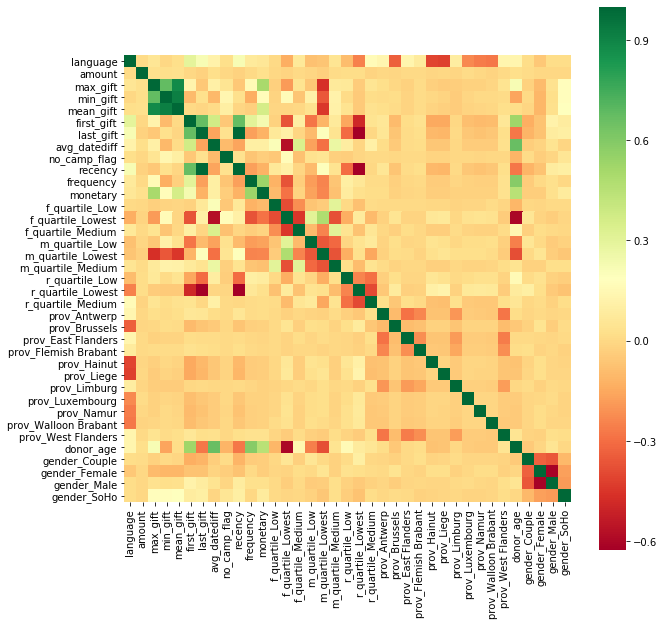

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

#Examining variable correlation through a heatmap

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(dsc_train[dsc_train.columns[~dsc_train.columns.isin(['y'])]].corr(),square=True,cmap='RdYlGn',ax=ax)

In [181]:
#Splitting train set for validation
from sklearn.model_selection import train_test_split

X = dsc_train[dsc_train.columns[~dsc_train.columns.isin(['y'])]]
y = dsc_train[['y']]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify = y)

In [182]:
#Saving a copy to use later for developing profile donor
testSet  = dsc.copy()

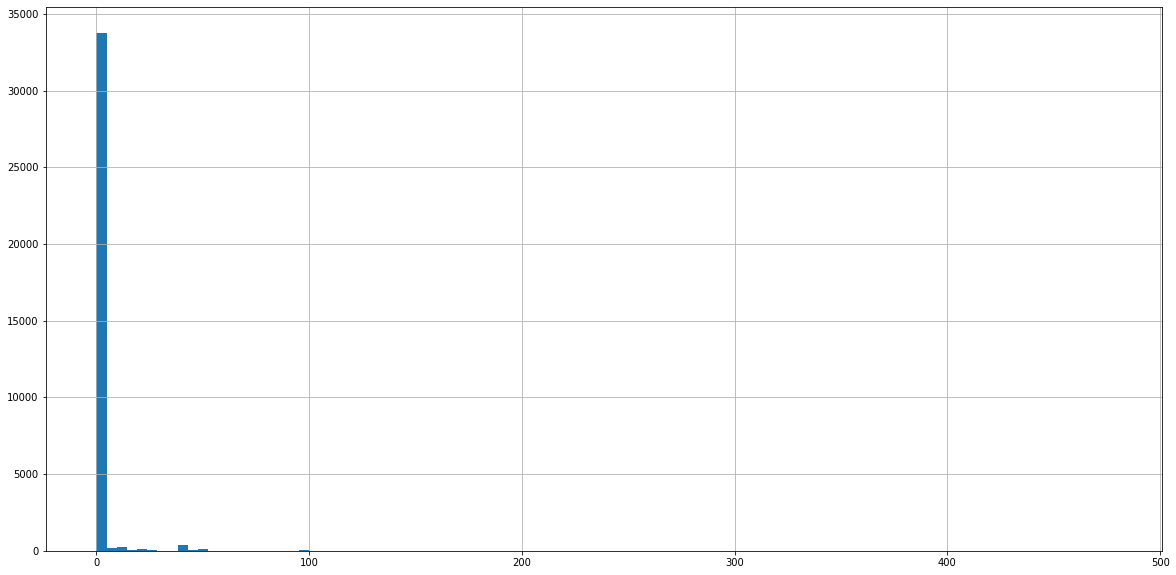

In [183]:
#Histogram of the amount in the trainin set shows skewed data
dsc_train['amount'].hist(bins=100)

In [184]:
#Upsampling observations with amount > 35 in training Set
#Function resamp defined for iterating and optimizing model selection

from sklearn.utils import resample

def resamp(appended_rows = 22000, dsc_split = pd.concat([y_train, X_train],axis=1,join='inner').reset_index(drop=True)):
    
    global X_train
    global y_train
    
    df_majority = dsc_split[dsc_split.y==0]
    df_minority = dsc_split[dsc_split.y==1]
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     
                                     n_samples= appended_rows, #51,
                                     )
    df_upsampled = pd.concat([dsc_split, df_minority_upsampled])

    y_train = pd.DataFrame(df_upsampled.y, columns = ['y'])
    X_train = df_upsampled.drop('y', axis=1)
    print("Data Resampled", appended_rows)

In [185]:
resamp()

Data Resampled 22000


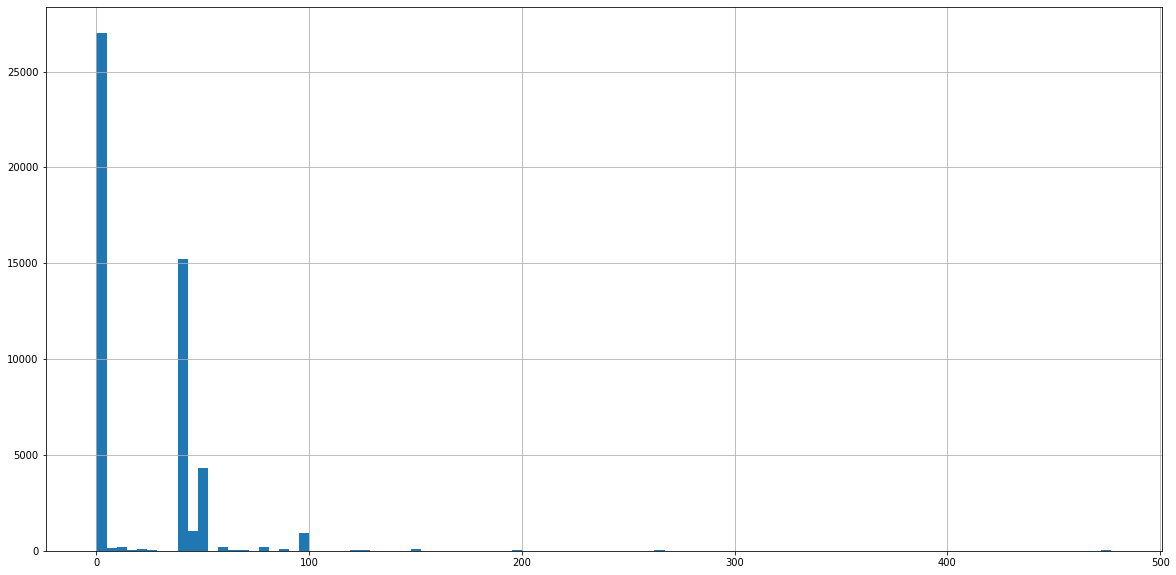

In [186]:
#Upsampled represenatation of the histogram 
X_train["amount"].hist(bins=100)

# Model Building
The models shown below were the ones with best performance after hypertuning the parameters and using different resampling techniques (undersampling, resampling and SMOTE). 
The models we tested were: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, KNeighborsClassifier, XGBoost, GradientBoostingClassifier, SVM (SVC), NeuralNetworks (MLPClassifier and MLPRegressor), LinearRegression, Lasso, Ridge.
The original code for testing models can be found in the Appendix.

In [187]:
from sklearn.linear_model    import LogisticRegression
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import auc
from sklearn.metrics         import f1_score, recall_score
from sklearn.metrics         import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics         import confusion_matrix

tree         = DecisionTreeClassifier(max_depth=6) 

logistic     = LogisticRegression(solver = "lbfgs", max_iter= 400) 

randomForest = RandomForestClassifier(max_depth=3, max_leaf_nodes = 6)

neighbors    = KNeighborsClassifier(weights = "distance", n_neighbors=4)

models = {
          #"logistic"     :logistic,
          "randomForest" :randomForest
         }

In [188]:
#Variable nofeature created with columns to be excluded from features
nofeature = ["y","amount"]
features = list(set(dsc.columns).difference(set(nofeature)))
target= 'y'

In [189]:
#Stepwise Feature Selection, as a function for iteration purposes and the possibility to select different evaluation metrics

def stepwise(eval_metric = auc):
    e_metrics = ["auc", "f1score & missed_true", "f1score"]
    print("Evaluation based on: ", e_metrics[eval_metric - 1])
    score_list = []
    performances = {}

    for model in models:
        score_list = []
        winners = []

        for index, var in enumerate(features):
            new_feat = []
            for i in range(len(features)):
                if features[i] not in winners:
                    new_feat = winners.copy()
                    new_feat.append(features[i])
                    models[model].fit(X_train[new_feat], y_train[target])
                    predictions   = models[model].predict(X_valid[new_feat])
                    probabilities = pd.DataFrame(models[model].predict_proba(X_valid[new_feat]))[1]
                    auc           = roc_auc_score(np.array(y_valid),np.array(probabilities))
                    f1score       = f1_score(y_valid, predictions)
                    specifity     = confusion_matrix(y_valid, predictions)[1][1]
                    missed_true   = confusion_matrix(y_valid, predictions)[1][0]
                    conf_prec     = confusion_matrix(y_valid, predictions)[1][1]/(confusion_matrix(y_valid, predictions)[1][1] 
                                                                          + confusion_matrix(y_valid, predictions)[0][1])
                    
                    #second parameter below (score_list[1]) is used for model evaluation
                    score_list.append([features[i], auc, f1score, f1score, missed_true, conf_prec]) 
                    if len(score_list) > 1:
                        if (eval_metric == 2):
                            if (score_list[1][eval_metric] > score_list[0][eval_metric]) & (score_list[1][4] < score_list[0][4]):
                                del(score_list[0])
                            else:
                                del(score_list[1])
                        else:
                            if (score_list[1][eval_metric] > score_list[0][eval_metric]):
                                del(score_list[0])
                            else:
                                del(score_list[1])

            if score_list[0][0] not in winners:
                winners.append(score_list[0][0])
            else:
                continue

        print(model, winners, "\n Conf_prec: ", score_list[0][2], "\n AUC: ", score_list[0][1])
        performances[model] = {"Features":winners, "AUC": score_list[0][1], "Conf_prec": score_list[0][5], "F1_Score": score_list[0][3]} 
    perform = pd.DataFrame(performances)
    return perform

In [190]:
#Confusion Matrix

def confusion(perform):
    global perform_conf
    global final_features
    final_features = perform.iloc[len(step)-1,:]
    performances_conf = {}

    for i in range(0,len(final_features)):
        model         = final_features.index[i]
        models[model].fit(X_train[final_features[i]], y_train)
        
        predictions   = models[model].predict(testSet[final_features[i]])
        
        probabilities = pd.DataFrame(models[model].predict_proba(testSet[final_features[i]]))[1]
        
        auc           = roc_auc_score(np.array(testSet[target]),np.array(probabilities))
        cv_score      = cross_val_score(models[model], X_train[final_features[i]], y_train, cv=5, scoring='roc_auc')
        
        f1score       = f1_score(testSet[target], predictions)
        conf_prec     = confusion_matrix(testSet[target], predictions)[1][1]/(confusion_matrix(testSet[target], predictions)[1][1] 
                                                              + confusion_matrix(testSet[target], predictions)[0][1])
        performances_conf[model] = predictions

        print(model, final_features[i], "\n AUC", auc, "\n Conf prec", conf_prec, "\n CV Score: ", cv_score, 
              "\n", confusion_matrix(testSet[target], predictions))
        print("")
    perform_conf = pd.DataFrame(performances_conf)

In [191]:
resamp(22000)

Data Resampled 22000


In [192]:
# 1 = auc, 2 = f1score & missed_true, 3 = f1score
# F1Score was used in the final model
step = stepwise(3)

Evaluation based on:  f1score
randomForest ['mean_gift', 'r_quartile_Medium', 'r_quartile_Lowest', 'prov_Namur', 'prov_Brussels', 'frequency', 'gender_Couple', 'prov_Liege'] 
 Conf_prec:  0.06976744186046512 
 AUC:  0.6372469193835409


In [193]:
step

,randomForest
AUC,0.637247
Conf_prec,0.0410959
F1_Score,0.0697674
Features,"[mean_gift, r_quartile_Medium, r_quartile_Lowe..."


In [194]:
confusion(step)

randomForest ['mean_gift', 'r_quartile_Medium', 'r_quartile_Lowest', 'prov_Namur', 'prov_Brussels', 'frequency', 'gender_Couple', 'prov_Liege'] 
 AUC 0.6719867481645428 
 Conf prec 0.011205887272119084 
 CV Score:  [0.6659276  0.68571245 0.69166567 0.68916036 0.68713882] 
 [[19580  5912]
 [   85    67]]



In [195]:
#Profile of donor (target)

chosen_model            = "randomForest"

perform_conf["actual"] = ["0"] * len(perform_conf)
perform_conf["donorID"] = ["0"] * len(perform_conf)
perform_conf.actual = testSet[target].copy()
perform_conf.donorID = dsc_copy["donorID"]

perform_conf_1 = perform_conf[perform_conf.actual == 1]

mod_feat = final_features[0].copy()
mod_feat.append("donorID")
mod_feat.append("y")
mod_feat.append("mean_gift")
mod_feat.append("max_gift")
mod_feat.append("amount")
mod_feat.append("first_gift")
mod_feat.append("last_gift")
mod_feat.append("Province")
mod_feat.append("gender")
mod_feat.append("donor_age")
df_mod_feat = dsc_copy.loc[:, mod_feat]

left_table = perform_conf_1.copy()
right_table = df_mod_feat.copy()

left_table.reset_index(drop=True,inplace=True)
right_table.reset_index(drop=True,inplace=True)

profile = pd.merge(left_table, right_table, 
         how="left", 
         left_on="donorID", 
         right_on="donorID")


In [196]:
#Filtering profile dataframe to look at descriptive statistics
profile[profile[chosen_model]==1].describe()

,randomForest,actual,donorID,mean_gift,r_quartile_Medium,r_quartile_Lowest,prov_Namur,prov_Brussels,frequency,gender_Couple,prov_Liege,y,mean_gift,max_gift,amount,first_gift,last_gift,donor_age
count,52.0,52.0,52.000000,52.000000,52.000000,52.000000,52.0,52.0,52.000000,52.000000,52.0,52.0,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,1.0,1.0,121645.442308,34.664402,0.057692,0.615385,0.0,0.0,7.173077,0.230769,0.0,1.0,34.664402,41.302115,44.134615,9.461538,3.538462,5.923077
std,0.0,0.0,12489.551772,10.732103,0.235435,0.491251,0.0,0.0,7.275317,0.425436,0.0,0.0,10.732103,13.668084,11.911485,4.746357,1.787336,4.846046
min,1.0,1.0,102410.000000,20.625000,0.000000,0.000000,0.0,0.0,1.000000,0.000000,0.0,1.0,20.625000,30.000000,40.000000,2.000000,1.000000,0.000000
25%,1.0,1.0,111290.250000,30.000000,0.000000,0.000000,0.0,0.0,1.750000,0.000000,0.0,1.0,30.000000,32.230000,40.000000,6.000000,2.750000,0.750000
50%,1.0,1.0,122077.000000,31.655571,0.000000,1.000000,0.0,0.0,5.000000,0.000000,0.0,1.0,31.655571,39.500000,40.000000,10.000000,3.000000,6.000000
75%,1.0,1.0,131497.750000,39.000000,0.000000,1.000000,0.0,0.0,10.500000,0.000000,0.0,1.0,39.000000,41.000000,40.000000,13.000000,4.000000,9.000000
max,1.0,1.0,144371.000000,100.000000,1.000000,1.000000,0.0,0.0,41.000000,1.000000,0.0,1.0,100.000000,100.000000,100.000000,18.000000,12.000000,16.000000


In [197]:
#Importing package to visualize different decision tress from random forest model

from sklearn.tree import export_graphviz

chosen_features = final_features[0]

i_tree = 0
for tree_in_forest in randomForest.estimators_:
    if (i_tree <1): #selecting one tree to display
        export_graphviz(tree_in_forest,
                        feature_names=chosen_features,
                        filled=True,
                        rounded=True, out_file="tree_best.dot")

# Tree Visualization
![graphviz.png](graphviz.png)
from IPython.display import Image
Image(filename = 'C:/Users/pborchert/Documents/GitHub/DSC_Project/graphviz.png')

# ROC Curve & Lift & Gains


In [198]:
trainingSet = pd.concat([X_train,y_train],axis=1,join='inner')
trainingSet.reset_index(drop=True,inplace=True)
testSet     = dsc.copy()
testSet.reset_index(drop=True,inplace=True)
ValidationSet = pd.concat([X_valid,y_valid],axis=1,join='inner')
ValidationSet.reset_index(drop=True,inplace=True)

In [199]:
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

features = list(step.loc['Features',:][0])

#Loop for building lifts and gains 

lifts     = {}
responses = {}
gains     = {}
data      = pd.DataFrame(testSet[target]).copy()

for (index,model) in enumerate(models):
    feature = step.loc["Features", model]
    models[model].fit(trainingSet[feature], trainingSet[target])
    data[f"proba {model}"] = pd.DataFrame(models[model].predict_proba(testSet[feature]))[1]
    lifts[model] = lift(dataSet = data, actuals = target, probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = target, probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = target, probability = "proba "+str(model))

lifts_randomforest=pd.DataFrame(lifts['randomForest'])
lifts_randomforest.loc[:,'Model']="randomforest"

pysqldf("""
select*
from lifts_randomforest
""").to_csv(path + 'liftsofall.csv')

gains_randomforest=pd.DataFrame(gains['randomForest'])
gains_randomforest.loc[:,'Model']="randomforest"

pysqldf("""
select*
from gains_randomforest
""").to_csv(path + 'gainsofall.csv')

responses_randomforest=pd.DataFrame(responses['randomForest'])
responses_randomforest.loc[:,'Model']="randomforest"

pysqldf("""
select*
from responses_randomforest
""").to_csv(path+'responsesofall.csv')

## ROC curve 

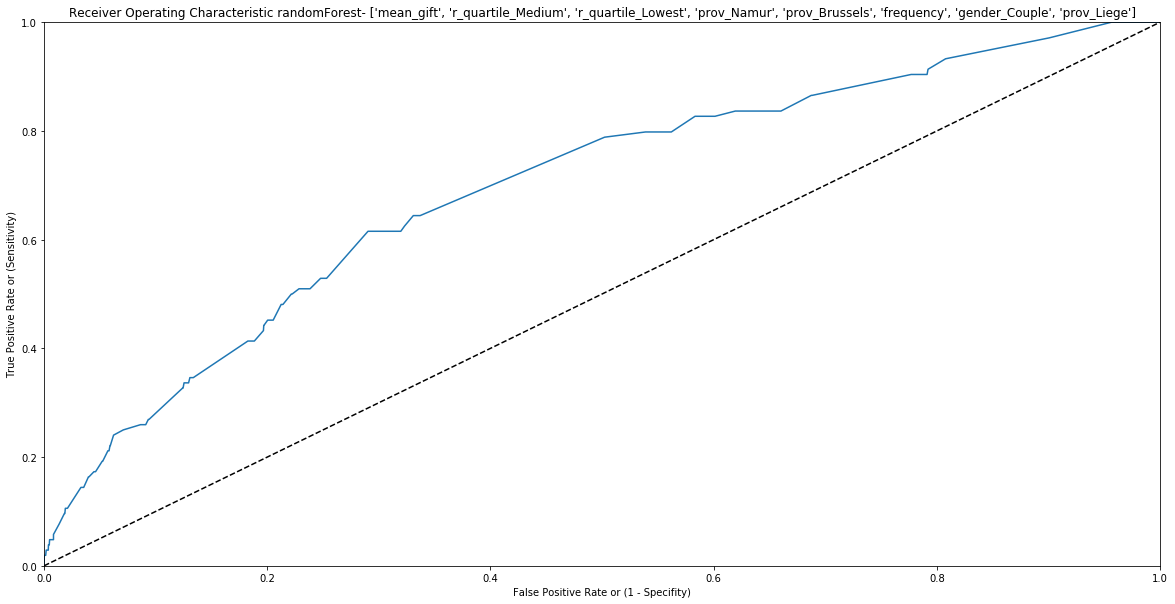

In [200]:
for model in models:
    models[model].fit(ValidationSet[step[model]['Features']], ValidationSet[target])
    ValidationSet.loc[:, 'predictProba'] = pd.DataFrame(models[model].predict_proba(ValidationSet[step[model]['Features']]))[1]
    rocTraining = roc(dataSet = ValidationSet, actuals = target, probability = "predictProba")
    
    pyplot.plot(rocTraining["False positive rate"], rocTraining["True positive rate"])
    pyplot.plot([0, 1], [0, 1], 'k--')
    pyplot.xlim([0.0, 1.0])
    pyplot.ylim([0.0, 1.0])
    pyplot.xlabel("False Positive Rate or (1 - Specifity)")
    pyplot.ylabel("True Positive Rate or (Sensitivity)")
    pyplot.title("Receiver Operating Characteristic " + model + "- "+ str(step[model]['Features']) )
    pyplot.rcParams["figure.figsize"] = (20,10)
    pyplot.show()

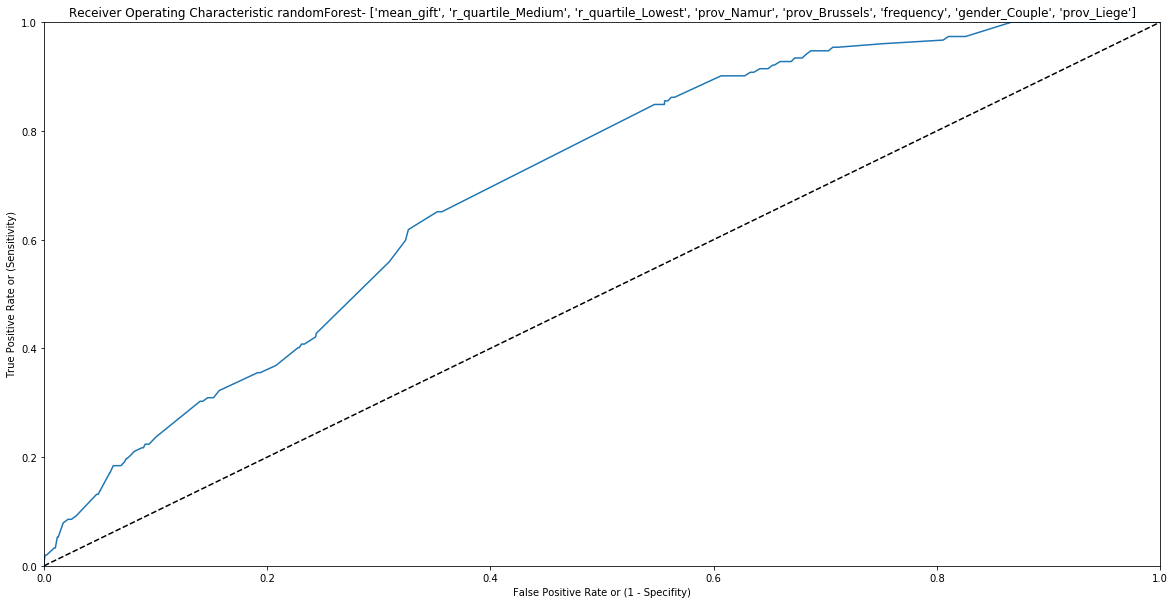

In [201]:
for model in models:
    models[model].fit(testSet[step[model]['Features']], testSet[target])
    testSet.loc[:, 'predictProba'] = pd.DataFrame(models[model].predict_proba(testSet[step[model]['Features']]))[1]
    rocTraining = roc(dataSet = testSet, actuals = target, probability = "predictProba")
    
    pyplot.plot(rocTraining["False positive rate"], rocTraining["True positive rate"])
    pyplot.plot([0, 1], [0, 1], 'k--')
    pyplot.xlim([0.0, 1.0])
    pyplot.ylim([0.0, 1.0])
    pyplot.xlabel("False Positive Rate or (1 - Specifity)")
    pyplot.ylabel("True Positive Rate or (Sensitivity)")
    pyplot.title("Receiver Operating Characteristic " + model + "- "+ str(step[model]['Features']) )
    pyplot.rcParams["figure.figsize"] = (20,10)
    pyplot.show()

# Appendix
The commented code in the first cell below shows the original models we tested. The second cell is a loop to optimize model and resampling selection using previously defined functions and selected evaluation metrics.
The third cell displays the different resampling techniques tried. The fourth cell displays different transformation techniques tried on continuous variables because of skewness.

In [202]:
# from sklearn.linear_model    import LogisticRegression
# from sklearn.linear_model    import LinearRegression
# from sklearn.linear_model    import Ridge
# from sklearn.linear_model    import Lasso
# from sklearn.tree            import DecisionTreeClassifier
# from sklearn.ensemble        import RandomForestClassifier
# from sklearn.ensemble        import GradientBoostingClassifier
# from sklearn.svm             import SVC
# from sklearn.neural_network  import MLPClassifier
# from sklearn.neural_network  import MLPRegressor
# from sklearn.neighbors       import KNeighborsClassifier
# from sklearn.metrics         import accuracy_score
# from sklearn.metrics         import auc
# from sklearn.metrics         import roc_auc_score
# from sklearn.model_selection import cross_val_score
# import xgboost as xgboost

# trainingSet = pd.concat([X_train,y_train],axis=1,join='inner').reset_index(drop=True)
# testSet     = dsc
# validationSet = pd.concat([X_valid,y_valid],axis=1,join='inner').reset_index(drop=True)

# nofeature = ["y", "mean_gift","amount"]
# features = list(set(dsc.columns).difference(set(nofeature)))
# target= 'y'

# tree         = DecisionTreeClassifier(class_weight = "balanced", max_depth=6)
# logistic     = LogisticRegression(solver = "lbfgs", class_weight = "balanced", max_iter= 200) # max_iter = 5000, penalty="l2",lbfgs 
# linear       = LinearRegression()
# ridge        = Ridge(alpha = 0.5, normalize=True)
# lasso        = Lasso(alpha = 0.5, normalize=False)
# randomForest = RandomForestClassifier(class_weight = "balanced", n_estimators = 100, max_depth=10)
# boostedTree  = GradientBoostingClassifier(max_depth=10)
# svm          = SVC(probability = True, class_weight='balanced', kernel='linear')
# neuralNet    = MLPClassifier()
# neuralNet_reg= MLPRegressor(solver="lbfgs")
# neighbors    = KNeighborsClassifier(weights = "distance", n_neighbors=9)
# xgb          = xgboost.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

# models = {"tree"         :tree,
#           "logistic"     :logistic,
#           "linear"       :linear,
#           "randomForest" :randomForest,
#           "boostedTree"  :boostedTree,
#           "svm"          :svm,
#           "neuralNet"    :neuralNet,
#           "neighbors"    :neighbors,
#           "XGBoost"      :xgb
#          }

In [203]:
#Model Selection Loop

# resamp_list = [15500, 17000, 19000, 20000, 22000, 25000, 27500, 30000]

# for rows in resamp_list:
#     print("################################################################################################################")
#     resamp(rows)
#     for eval_metric in range(2,4):
#         step = stepwise(eval_metric)
#         confusion(step)
#         print("------------------------------------------------------------------------------------------------------------")
#     print("################################################################################################################")

In [204]:
#resampling observations with amount > 35 in training Set for imbalanced y variable
#source: https://towardsdatascience.com/what-to-do-when-your-classification-dataset-is-imbalanced-6af031b12a36

# from sklearn.utils import resample
# dsc_split = pd.concat([y_train, X_train],axis=1,join='inner').reset_index(drop=True)
# df_majority = dsc_split[dsc_split.y==0]
# df_minority = dsc_split[dsc_split.y==1]
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,     
#                                  n_samples=len(df_minority), #to match majority class size
#                                  )
# df_upsampled = pd.concat([dsc_split, df_minority_upsampled])

# y_train = pd.DataFrame(df_upsampled.y, columns = ['y'])
# X_train = df_upsampled.drop('y', axis=1)

# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state=27, ratio=1.0)
# X_train, y_train = sm.fit_sample(X_train, y_train)
# y_train = pd.DataFrame(y_train, columns = ['y'])
# X_train = pd.DataFrame(X_train, columns = X.columns)

# from sklearn.utils import resample
# dsc_split = pd.concat([y_train, X_train],axis=1,join='inner').reset_index(drop=True)
# df_majority = dsc_split[dsc_split.y==0]
# df_minority = dsc_split[dsc_split.y==1]
# downsampled = resample(df_majority, 
#                        replace=True, # sample with replacement
#                        n_samples=len(df_minority), # match number in minority class
#                        random_state=27) # reproducible results
# # combine minority and downsampled majority
# downsampled = pd.concat([df_minority, downsampled])
# # check new class counts
# y_train = downsampled[['y']]
# X_train = downsampled.drop('y', axis=1)

# y_train.y.value_counts()

In [205]:
#Data Transformation for continuous skewed variables 

# #First scaling attempt
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X2 = dsc_train.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'frequency', 'avg_datediff']].values
# X3 = scaler.fit_transform(X2)
# dsc_train[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'frequency', 'avg_datediff']] = X3
# X2 = dsc.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'frequency', 'avg_datediff']].values
# X3 = scaler.fit_transform(X2)
# dsc[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'frequency', 'avg_datediff']] = X3

# #Second scaling attempt
# from sklearn.preprocessing import scale
# X2 = dsc_train.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'frequency', 'avg_datediff']].values
# X3 = scale(X2)
# dsc_train[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'frequency', 'avg_datediff']] = X3
# X2 = dsc.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'frequency', 'avg_datediff']].values
# X3 = scale(X2)
# dsc[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'frequency', 'avg_datediff']] = X3

# #Third scaling attempt: log transformation
# X2 = np.log(dsc_train.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'frequency', 'avg_datediff']]+1)
# dsc_train[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'frequency', 'avg_datediff']] = X2
# X2 = np.log(dsc.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'frequency', 'avg_datediff']]+1)
# dsc[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'frequency', 'avg_datediff']] = X2

# #Fourth scaling attempt: Normalizing + Log
# #Source: https://towardsdatascience.com/transforming-skewed-data-73da4c2d0d16
# def normalize(column):
#     upper = column.max()
#     lower = column.min()
#     y = (column - lower)/(upper-lower)
#     return y
# X2 = normalize(np.log(dsc_train.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'frequency', 'avg_datediff']]+1))
# dsc_train[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'frequency', 'avg_datediff']] = X2
# X2 = normalize(np.log(dsc.loc[:,['max_gift', 'min_gift', 'first_gift','mean_gift',
#       'last_gift', 'frequency', 'avg_datediff']]+1))
# dsc[['max_gift', 'min_gift', 'first_gift','mean_gift',
#        'last_gift', 'frequency', 'avg_datediff']] = X2

# #Fifth scaling attempt: Yeo-Johnson transformation, as it supports non-positive values (0s, unlike boxcox)
# from sklearn.preprocessing import power_transform
# skew = ['max_gift', 'min_gift', 'first_gift','mean_gift', 'last_gift', 'frequency', 'avg_datediff']

# for feat in skew:
#     print(feat)
#     dsc_train[[feat]] = power_transform(dsc_train.loc[:,[feat]], method='yeo-johnson')
#     dsc[[feat]] = power_transform(dsc.loc[:,[feat]], method='yeo-johnson')

# Model Continous (work in progress)

In [206]:
#Continous PCA
#testSet[target].hist(bins=100) 
#skewed: max_gift,min_gift,mean_gift,frequency,avg_datediff



# from sklearn.decomposition import PCA
# from sklearn.metrics       import mean_squared_error

# testSet[target] = np.log(testSet[target] + 1)
# trainingSet[target] = np.log(trainingSet[target] + 1)

# def normalize(column):
#     upper = column.max()
#     lower = column.min()
#     y = (column - lower)/(upper-lower)
#     return y

# models = {"neuralNet_reg":neuralNet_reg,
#           "linear"       :linear,
#           "XGBoost"      :xgb,
#           "Lasso"        :lasso
#          }

# nofeature = ["y", "amount"]
# features = list(set(dsc.columns).difference(set(nofeature)))
# target= 'amount'
# skew = ['max_gift','min_gift','mean_gift','frequency','avg_datediff']

# for i in trainingSet[features]:
#     if i in skew:
#         trainingSet[i] = normalize(np.log(trainingSet[i]+1))
#         testSet[i] = normalize(np.log(testSet[i]+1))


# #pca = PCA()
# #pca_train = pca.fit_transform(trainingSet[features].values)
# #pca_test = pca.transform(testSet[features].values)

# # exp_var_pca = pca.explained_variance_ratio_

# # pca_train = pca_train
# # pca_test = pca_test

# skipped=[]
# performances = {}

# for model in models:
#     #models[model].fit(pca_train, trainingSet[target])
#     models[model].fit(trainingSet[features], trainingSet[target])
#     print(f"{model} has been trained successfully")
# for model in models:
#     if model not in skipped:
#         #predictions      = models[model].predict(pca_test)
#         predictions      = models[model].predict(testSet[features])
#         RMSE             = np.sqrt(mean_squared_error(testSet[target],predictions))
#         mean_train       = np.mean(testSet[target])
#         score            = RMSE / (testSet[target].max() - testSet[target].min())
#         print(model, score)
#         performances[model] = predictions
# pd.DataFrame(performances).head()
# perform = pd.DataFrame(performances)

In [207]:
# perform["actual"] = ["0"] * len(perform)
# perform.actual = np.exp(testSet[target]) - 1

# for mod in range(len(perform.columns)-1):
#     x = perform["actual"] - perform.iloc[:, mod]
#     print(perform.columns[mod], "\t", x.mean())
# perform[perform.actual != 0].head(50)
# #perform.head(50)

In [208]:
# for i in ["neuralNet_reg","linear","XGBoost","Ridge"]:
#     fig, ax = plt.subplots(figsize=(2,2))
#     plt.scatter(perform[i],perform['actual'])
#     plt.title(i)
#     plt.show()